<a href="https://colab.research.google.com/github/wooohoooo/Thompson-Sampling-Examples/blob/master/Handmade_Bandit_solvers_Linear_Context.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook continues the series about multi-armed bandit (MAB) solutions.
This time we will look at MAB with linear contexts. To understand this, you should at least have an understanding of non-contextual Thompson Sampling, as presented e.g. here [link other notebook].

Like in the previous post, we will first look at the problem at hand and how we can emulate a an environment that can benefit from a contextual MAB solver.
In the previous entry, we looked into the problem of how to find out which arm is better, such as whether a red button or a blue button is likely to generate more traffic to our website, or whether Neo is more likely to choose the red or the blue pill so we can hide the tracer inside (I rewatched the move in the mean time and am now more up to date).

This time, we will add context to the decision, this could be the users age, the users gender, the users education, any other information about the user or any combination thereof. In general, we want to use all the information available to us to make sure our decision is well informed; but in this case we will go for a context of two variables to make sure we can visualize it nicely. 
In our case, it will be the age of the user and whether he has a dog or not; because with age their eyesight grows worse so they don't see th button as well, but people with a dog are more trained to spot small things so less so for them. All correlations in this example are (obviously) completely made up.

![alt](https://live.staticflickr.com/2655/3933458622_3d0956e72d_b.jpg)
(I couldn't find an image of a dog as bandit, so this pawrate will have to be enought)


As we learned last time, in order to use Thompson Sampling, we need distributions over the expected outcome of each arm; while we were using simple beta binomials for the non-contextual case, now we will be using Normal Distributions. Since we also want to include context, we need a way of generating these distributions from a model that incorporates this context. 
For this simple notebook, we will walk through a contextual example using a normal distribution derived via Bayesian Linear Regression. More complex solutions exist, notably one introduced in this paper: ![TS with Online Bootstrap](https://arxiv.org/abs/1410.4009).

Again, this is aimed at application designers rather than students of th mathematicl descriptions behind Thompson Sampling. A primer and possibly a deeper explanation on these topics migh follow in the future. 

But let's take a step back and look at the problem we're trying to solve.






# getting ready 

In [0]:
#maths
import numpy as np
import scipy.stats as stats
from sklearn.utils import shuffle

np.random.seed(42)

In [0]:
#pretty things

matplotlib_style = 'seaborn-notebook' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
import matplotlib.cm as cm

%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

width = "16" #@param [16,8,25]
height = "4.5" #@param [4.5, 9,16,8,25]
width = int(width)
height = float(height)


plt.rcParams['figure.figsize'] = width,height


In [0]:
#set some parameters

# number of features
num_features = "1" #@param [1, 2,3,50]
num_features = int(num_features)

# data size
num_data = "100" #@param[25,100]
num_data = int(num_data)


# slopes of reward depending for arm 1 and arm 2
theta1 = 2
theta2 = 10
theta = [int(theta1), int(theta2)]

# noise in the data
noise = "5" #@param [1,5,10,100]
noise = int(noise)


# scale of uncertainty
v = "50"#@param [1,10, 50, 100]

v = int(v)


# What is a contextual multi armed bandit situation?

The contextual multi armed bandit situation is similar to the one we encountered previously. We have a deicsion to make, and depending on that decision, we will get a reward. Not much new, so far. We want to know whether a dog on our website makes the user pay more for our product, think Humble Bundle.

As we did last time, we have to define a 'user' that will react to the arms we play. And as last time, we do this via a function called 'customer_reaction'. 

However, this time we have have some information about the user, formally known as context. In this case, it is the users age (1). We think that depending on how old the users are, they will react DIFFERENTLY to whether a dog is present or not. Here it is 'the older you are, the more you spending increases when you see a dog', meaning showing people a dog is the best decision above a certain age; below that age we're more likely to receive more money if we DO NOT SHOW A DOG.


This we'll model as a linear slope with 

$y = x \cdot m + t + \epsilon $

where 
$y$ is the target, i.e. how much the user spends

$x$ is the context, i.e. the users age

$m$ is a linear factor decided by whether a dog is present or not

$t$ is the onset; in our case that is 0

$\epsilon$ is gaussian noise, since we're still in a probabilistic setting


 (1) the users age is between -10 and 10 in this case. If you have a problem with this... redo this notebook with more sensible numbers. Have fun! 


In [0]:
X_ = np.array([1,2,3])
arm = np.array([1,2])

num_arms = 1
num_contexts = 1
#num_data = 1000

#create X
X = np.zeros((num_data,num_contexts + num_arms))


for i in range(num_contexts):
    X[:,i] = np.linspace(-10,10,num_data).T
    
for i in range(num_arms):
    X[:,i+num_contexts] = np.random.binomial(1,.6,num_data)
X[:5,:]

X = shuffle(X)

 

In [0]:
def customer_reaction(context, choice, theta = theta, noise=noise):
  features  = np.append(context,choice)


  # decide on which slope to use depending on whether a dog is present or not
  m = theta[0] if features[1] else theta[1]

  # $y = x \cdot m + t + \epsilon $
  y = features[0] * m + np.random.normal(0,noise)


  return y


In [6]:
customer_reaction([9.0],1)

17.282688851846554

In [7]:
customer_reaction([9.0],0)

93.08501887857565

In [0]:

y = []
for i in range(num_data):
  context = X[i][0]
  choice = X[i][1]
  outcome = customer_reaction(context,choice)
  y.append(outcome)

y = np.array(y).flatten()


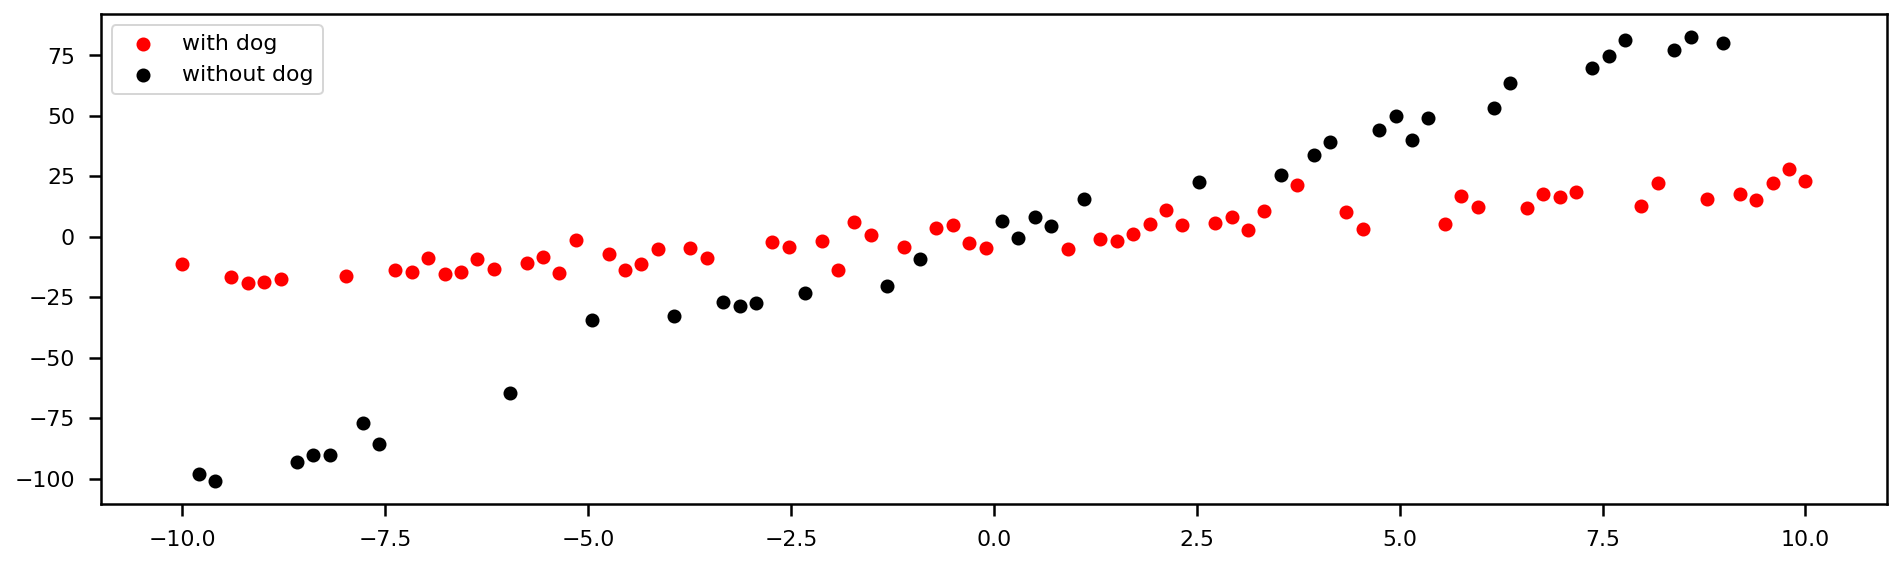

In [9]:
index = X[:,1] == True

plt.scatter(X[:,0][index],y[index],label='with dog',c='red')
plt.scatter(X[:,0][~index],y[~index],label='without dog',c='black')
plt.legend()

# Now that we have defined the Problem, let's solve it!

Remember the simple API we defined last time. We will reuse it.
We will implement a way of choosing an arm to play according to some policy, and we will implement a way of updating the policy with the observations. Note that this time, we add context to bith methods.




In [0]:
class AbstractContextualSolver(object):
  def __init__(self, model):
    self.model = model


  def choose_arm(self,context):
    """choose an arm to play according to internal policy"""
    raise NotImplementedError
        
  def update(self, arm, context, reward):
    """ update internal policy to reflect changed knowledge"""
    raise NotImplementedError

In [0]:
class LinearThompsonSampler(AbstractContextualSolver):

  def choose_arm(self,context):
    reward_list = []

    for i in range(len(self.arms)):
        mu, std = self.model.get_mean_std()

        dist = stats.multivariate_normal

        sample_slope = np.atleast_2d(dist.rvs(mean=mu_t.flatten(),cov=self.model.v**2*B_inv))
        print(sample_slope)

        reward = np.dot(b.T,sample_slope.T)
        reward = sample_slope
        reward_list += [reward]
    return np.argmax(reward_list)

  def update(self,arm,context,reward):
    self.model.update(arm,context,reward)

In [0]:
class BayesLinReg(object):

  def __init__(self, num_features=1,v=v):
    self.B = np.eye(num_features+1)
    self.Binv = np.linalg.inv(self.B)
    self.f = np.atleast_2d(np.zeros(num_features+1))
    self.v = v

    self.mu = np.zeros(num_features+1)

  def add_intercept(self,X):
    X_new = np.atleast_2d(np.insert(np.atleast_2d(X),0,1))
    return X_new.T


  def observe(self,x,y):
    y = np.atleast_2d(y)
    x = self.add_intercept(x)
    self.B += np.outer(x,x)
    self.f += np.dot(x,y).T


  def get_mean_std(self):
      B_inv = np.linalg.inv(self.B)
      mu_t = B_inv.dot(self.f.T)

      return mu_t, B_inv

      

#helpers
  def train(self,X,y,shuffle = True):
      index = list(range(X.shape[0]))
      if shuffle ==True:
          np.random.shuffle(index)
      for i in index:
          self.observe(X[i],y[i]) 
          

      
  def predict_ML(self,X):
      beta= np.linalg.inv(self.B).dot(self.f.T)

      y = []
      try:
          for i in range(len(X)):
              x = X[i]
              y += [self.predict_ML_x(x)]
              return y
      except:
          X = self.add_intercept(X)
          return X.T.dot(beta)
          




  def predict_ML_x(self,x):
      beta = np.linalg.inv(self.B).dot(self.f.T)
      x = self.add_intercept(x)
      return x.T.dot(beta)[0][0]

  def draw(self):
      B_inv = np.linalg.inv(self.B)
      mu_t = B_inv.dot(self.f.T)
      dist = stats.multivariate_normal
      return dist.rvs(mean=mu_t.flatten(),cov=self.v**2*B_inv)   

In [0]:
bl = BayesLinReg()
bl.train(X[:,0][index],y[index])


In [0]:
bl.train(X[:,0][index],y[index])


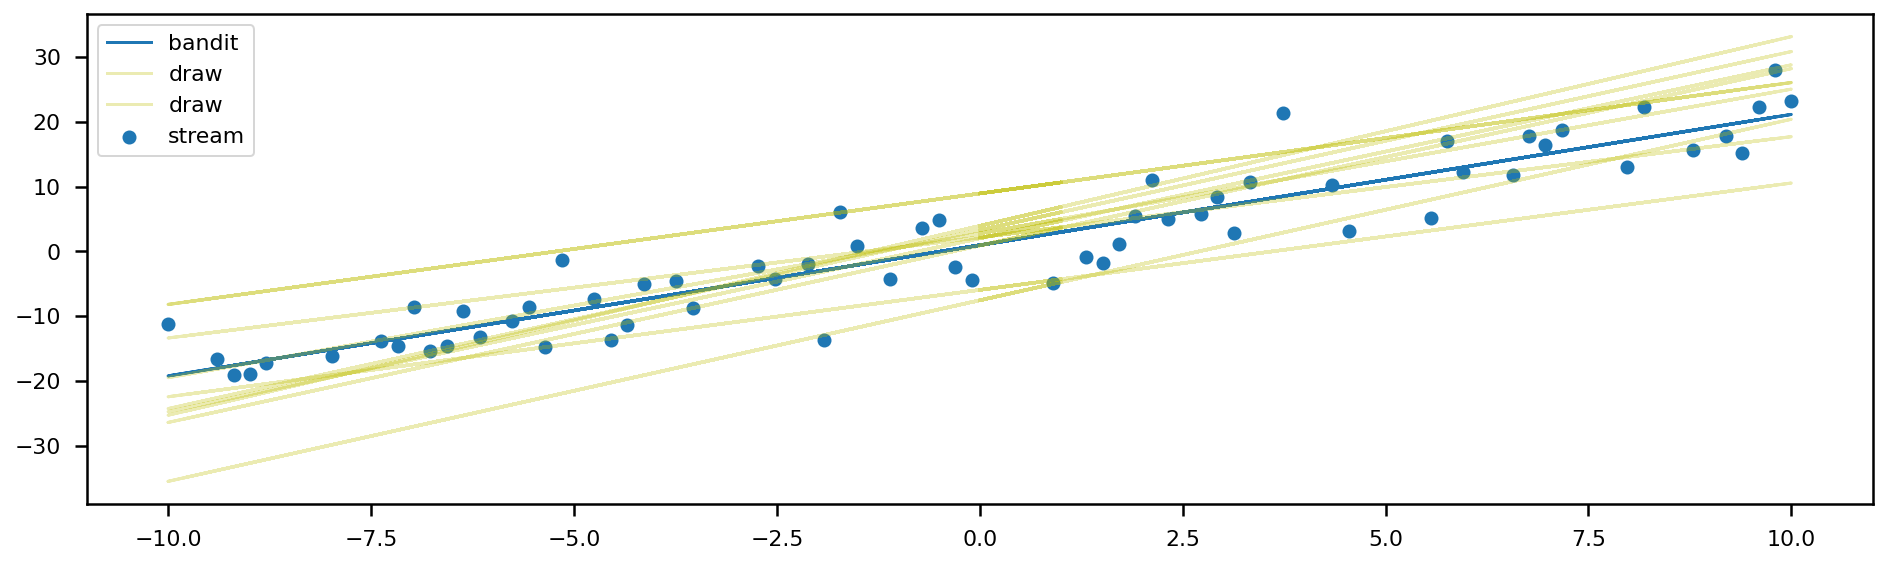

In [15]:
draw_list = []


num_draws = 10
#plt.scatter(X,y)

#plt.plot(X,regr.predict(X),label = 'ols',alpha=.3)
#plt.scatter(X,y_hat,color = 'r',label = 'ML')


y_hat = []

for i in range(len(X[index])):
    y_hat += [bl.predict_ML_x(X[:,0][index][i])]

y_hat = np.array(y_hat) 

plt.plot(X[:,0][index],y_hat,label='bandit')
plt.scatter(X[:,0][index],y[index],label='stream')

for i in range(num_draws-1):
    w = bl.draw()
    draw_list += [w]
#plt.plot(X,X*w,label='draws')
#draw = w.dot(test.add_intercept(X[1]))
#draw_list +=[draw]

    plt.plot(X,w[0]+w[1]*X,color = 'y',alpha=0.3)
plt.plot(X,w[0]+w[1]*X,label='draw',color = 'y',alpha=0.3)

plt.legend()

But wait! 
We learned last time that in order to do thompson sampling, we need a distribution to draw from per arm we want to play; this distribution reflects the likelihood for the reward we're likely to receive. 
We also know that distributions usually don't use context; $ \mathcal{N}(\mu,\sigma)$ relies only on the mean and the standard deviation of the data we have observed - but in our case, $\mu$ changes rapidly with depending on whether a dog is present or not.
What do we do?


We become Bayesian, that's what we do. Honestly, that should always be the first thing you do when facing a problem.

![alt](https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Bayes%27_Theorem_MMB_01.jpg/1200px-Bayes%27_Theorem_MMB_01.jpg)

More specifically, we will use a technique known as bayesian linear regression, which you can read about more about [here](https://en.wikipedia.org/wiki/Bayesian_linear_regression) and [here](https://towardsdatascience.com/introduction-to-bayesian-linear-regression-e66e60791ea7). Let's meet again after you checked those out. 



Hi! So now that you read that, you know how Bayesian Linear Regression can be used to derive a normal distribution depending on a linear model that we can train to give us everything we need. 
Let's do that. 



# What is a multi armed bandit situation?

In the multi armed bandit setting, we are tasked with finding the best performing action out of a selection of possible actions. An example could be the color of a button on a website. We could make it Blue or Yellow. Our theories are that Blue is easier to see but Yellow is a more inviting color. We now have to figure out which of these effects is stronger, i.e. which button color gets clicked more often(1).


We do not know which theory is correct, and, unfortunately, we will never KNOW which button is better, since for that we'd need to know what would have happened if the users that saw yellow were presented with blue and vice versa, for all eternity. Maybe the users that saw it so far preferred yellow because it was summer. Or the background of an ad that popped up made it very hard to see the blue button. 
This is, in essence, what we refer to as the dilemma of 'Exploration vs Exploitation': Do we rely on the information we have available to make a decision or do we want to collect more data so that our future decisions will be a better informed one?

![alt](http://www.primarydigit.com/uploads/2/0/1/6/20168087/2155136.png?387)

In this Notebook, we want to look at a few possible solutions to this problem.


# How do we test these approaches

To do so, we need to simulate a situation in which a customer makes a choice we do not know up front, since we don't have actual customers to ask. To do that, we generate an 'average customer'. This average customer is going to react to the color of the button with probabilities proportional to how the real population MIGHT react (this is of course simulated). This value is stored in our variable 'Theta'; it reflects how likely the general population is to click on a blue vs a yellow button. We convert this probability to a reaction by sampling a number between 0 and 1 and comparing it to the theta value for that choice, see customer_reaction().




 (1) This is not a real life situation, in which we might take into account different additional parameters such as page background - which we'd optimally test, too.

In [0]:
#convert arm to response depending on theta
def customer_reaction(choice, theta=theta):

    # draw a number between 0 and 1, if it's smaller than the theta, return reward
    if np.random.random() < theta[choice]:
        reaction = True
    else:
        reaction = False

    return reaction

In [17]:
customer_reaction(1)

True

In [18]:
customer_reaction(0)

True

In [19]:

if not use_random:
  mean_0 = np.mean([customer_reaction(0) for i in range(10)])
  mean_1 = np.mean([customer_reaction(1) for i in range(10)])
  print(f'empirical mean for choice 0 is {mean_0} (real value {theta[0]}), is {mean_1} (real value {theta[1]}) for choice 1')



NameError: ignored

The second thing we need to do in order to compare different approaches to solving the MAB problem is introduce a measure for the performance of different algorithms on 

# Now that the problem is defined, let's solve it

I will introduce two approaches, A/B testing and Thompson Sampling in detail and mention two others, epsilpon greedy and UCB, in passing.
But first, let's quickly introduce our general strategy:

## Abstract solution to Bandit Problems

In order to solve the problem posed above, we devise a simple black box strategy: 
We will build a system that chooses an arm (in our example, blue or yellow button) by some policy  and updates that policy based on what it observes (in our example: did the user click). This policy will be chosen to solve our exploration vs exploitation dilemma in some way.

Note that this is very general. On the one hand, this approach can house an ideterminate number of policies such as A/B testing, Thompson Sampler, ... ; on the other hand, this can be extended to many other problems solvable with reinforcement learning. 

Again, all we do in MAB problems is choose an action that seems favorable given an internal policy and update that policy given the reward our action produced.




In [0]:
class AbstractSolver(object):
    def choose_arm(self):
        """choose an arm to play according to internal policy"""
        raise NotImplementedError
        
    def update(self, arm, reward):
        """ update internal policy to reflect changed knowledge"""
        raise NotImplementedError



## A/B Test
A/B tests are the current standard for solving multi armed bandit dilemmas. They are being used in all kinds of situations and are very closely related to the gold standard of scientific experimentation.
The concept is simple and clear:

We split our users in two equal groups randomly and show them different options for a pre-determined number of trials - and then we decide to go with one of the options for the rest of the time. 
Note he explicit split into Exploration phase in which we randomly show different arms to observe the reward and the Exploitation phase in which we always play the arm that performed best during the exploration.

In reality, there are a few complex additions to how to condut an A/B test properly, like estimating the expected effect size and deciding beforehand how strong the difference in groups has to be for it to be considered valid, and that in turn is used to compute the sample size and... All these problems arise, because classical A/B tests are 'Frequentist' (named after people who believe that probabilities are closely related to frequencies - but: different topic) and thus we need to be careful not to screw up the decision process. We will ignore those extra points for the sake of clarity(2).

Below we implement an A/B test.




(2)If you're interested, these seem like two good resources to start: 
- https://towardsdatascience.com/the-art-of-a-b-testing-5a10c9bb70a4
- https://blog.hubspot.com/marketing/how-to-do-a-b-testing

In [0]:
class AB(AbstractSolver):
  def __init__(self, n_experiments=1000, num_options=num_options):
    self.trials = np.zeros(shape=(num_options,))
    self.successes = np.zeros(shape=(num_options,))
    self.experiments_done = 0
    self.n_experiments = n_experiments



  def choose_arm(self):
    """we choose to either randomly sample an arm 
    or play the previously determined best choice"""

    # if we need more experimentation, we explore
    if self.experiments_done < self.n_experiments:
      arm = self.explore()
    # otherwise, we exploit
    else:
      arm = self.exploit()
    return arm


  def update(self, arm, reward):
    """Updates the arms about being played and about receiving a reward"""

    # simply count the number of trials and successes for each arm
    self.trials[arm] += 1
    if reward:
      self.successes[arm] += 1
    self.experiments_done += 1


  def explore(self):
    """returns arm 0 or arm 1 depending on a draw from interval [0,1]
    NOTE: this isn't necessarilyhow you'd do it in real life, 
    please consult the sources for that case"""

    # literally choose by random which arm to return
    if np.random.random() <.5:
        return 0
    else:
        return 1

  def exploit(self):
    """returns arm with highest expected payoff
    Always the same arm after exploration phase"""

    # return the arm with the highest success rate
    return np.argmax(self.successes/self.trials)
  


In [0]:
ab = AB(n_experiments=100)

In [0]:
np.mean([ab.choose_arm() for x in range(1000)])

In [0]:
ab.update(1,1)

In [0]:
np.mean([ab.choose_arm() for x in range(1000)])

lets feed it 1000 experimental outcomes:

In [0]:
for i in range(101):
  arm = ab.choose_arm()
  reward = customer_reaction(arm,theta=[0.3,0.6])
  ab.update(arm,reward)

In [0]:
np.mean([ab.choose_arm() for x in range(500)])

As we can see, the experiment is finished, the ab tester will now always return one arm.

## Thompson Sampler

AB testing has a few drawbacks:

What do we do if the difference in our sample isn't large enough to confidently say one is better after the experiment was concluded?

What if we chose the number of people we're testing wrong and now instead of using the awesome blue button that seems to perform so much better we are now stuck with showing half of the users the ugly yellow one?! we're good scientists so we won't interrupt the experiment; if we're REALLY good scientist we won't even peek so we DON'T KNOW THAT OUR USERS ARE BEING LED ASTRAY BY OUR EVIL AMBER!

What if we realize that we performed our experiment during a time in which, for some reason, the users were not reacting as usually, maybe because everyone is acting irrationally and buying too much toilet paper? NOW WE ARE STUCK WITH THAT DASTARDLY DANDELLION BUTTON!

...What if we realize that we actually want to test a red button, too? WAAAAAAAAH!!!!!!!!


All these problems arise because we decided to have a clear distinction between exploration and exploitation. First we randomly sample user experiences so we can find out which one works better and then we stick to whatever comes out of that.
This leads to us being stuck the phase in which we either collect data from a random process we can't influence or the phase in which we use that information to ~~generate moneyz~~ make sure we offer our users an optimal experience, without being able to incorporate new evidence.

Wouldn't it be great if we could do both at the same time? Maybe by **updating the sampling scheme** used during the exploration so it doesn't just return either arm half the time but **increases the chance of seing the button that has been performing better in the past** each time we see it perform better? Wouldn't it be great if we could do that until the end of times because we do not need to decide when to stop the experiment because inherently, the best arm gets played most of the time anyways?

Yes that would be great. And we're doing it. It's called Thompson Sampling. 









Thompson Sampling was invented in 1933 and has been rediscovered a bunch of times since then (source: Wikipedia) because it is so fantastic. 
It is an inherently Bayesian approach (compared to 'Frequentist' from earlier), which for all intents and purposes means it operates on Probability Distributions rather than point estimates and uses something called a 'Prior'. For deeper discussions, feel free to hit me up on Slack :) 


![alt](https://image.slidesharecdn.com/atackingthemulti-armed-bandit-problem-slides-190517222554/95/claudia-vicol-solving-the-multi-armed-bandit-problem-codemotion-amsterdam-2019-18-638.jpg?cb=1558132137)


Our implementation relies on two methods, again:

Choose_arm, which 
*** for each arm draws from the distribution over the expected rewards*** (this will become easier to understand with the visualisations below!) and compares them to see which one is higher. This is where the 'constant exploration' is: even with very different distributions, sampling will *occasionally* allow for all arms to be played. 

The Update arm, which observes the reward after playing an arm and updates the distribution of that arm to reflect the new knowledge. This means two things: The distribution will get narrower (unless we have very diverging data) and its mean will move closer to what the model thinks the expected reward of an arm is. 

If we look back at the choose arm now - a narrower distribution translates into a narrower spread of likely values to be drawn from that distribution. This means - as the Thompson Sampler converges, each arms' sample will get more likely to be around a certain value - and thus the one with the higher expectation will be played more than the others.


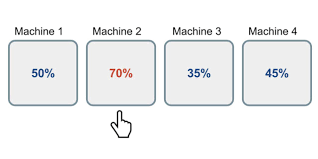

This means, while we managed to get rid of distinct exploration vs exploitation phases, we have a continuous shift from one to the other, meaning we're going to start exploiting more just as we have enough data to do so. 

Let's see what that looks like.

In [0]:
class BetaBandit(AbstractSolver):

    def __init__(self, num_options = 2, prior = None):
        """initialize BetaBandit"""
        self.num_options = num_options

        #setting the prior, either uninformative or user generated
        if prior == None:
            self.prior = np.ones(shape=(num_options,2))
        else:
            assert prior.shape == (num_options,2), f"the prior seems to have wrong dimensionality, please conform to (num_options, 2){(num_options,2)}"
            self.prior = prior

        self.trials = np.zeros(shape=(num_options,))
        self.successes = np.zeros(shape=(num_options,))


    def choose_arm(self):
        """draw from arms.
        arm with the highest expected outcome wins. 
        expected outcome is determined stochastically, so even an arm with bad 
        outcome until now will have a chance of being drawn"""

        sampled_theta=[]
        for i in range(self.num_options):

            dist = stats.beta(self.prior[i,0]+self.successes[i], 
                              self.prior[i,1]+self.trials[i] - self.successes[i])
                
            sampled_theta += [dist.rvs()]
      
        return(sampled_theta.index(max(sampled_theta)))    
        
    def update(self,arm,success):
        """update beta-parameters of specific arm"""
        #count times arm has been drawn"""
        self.trials[arm] = self.trials[arm] +1
        #count number of successes on that arm"""

        # self.successes = self.successes *.99
        if success:
            self.successes[arm] = self.successes[arm]+ 1
            





# Helper functions, non essential


    def choose_arm_and_plot(self):


        sampled_theta = []
        dist_heights = []

      
        for i in range(self.num_options):

            dist = stats.beta(self.prior[i,0]+self.successes[i], 
                              self.prior[i,1]+self.trials[i] - self.successes[i])
            sample = dist.rvs()
            sampled_theta += [sample]
            dist_heights += [dist.pdf(sample)]

            
        w = 10
        z = 5
        colors = iter(cm.rainbow(np.linspace(0, 1, self.num_options)))
            
        for k,i in enumerate(range(self.num_options)):
                color = next(colors)

                dist = stats.beta(self.prior[i,0] + self.successes[i],
                            self.prior[i,1] + self.trials[i] - self.successes[i])
                x = np.linspace(0,1,100)
                y = dist.pdf(x)
                plt.plot(x,y,color=color,label="arm #%i"%(i+1),alpha=0.8)

                plt.scatter(sampled_theta[i],dist_heights[i], s = 200,label=f'sample drawn from arm {i}')

                plt.fill_between(x,0,y,alpha=1/(self.num_options+1),color=color)
                leg = plt.legend()
                plt.tight_layout    
      
        return(sampled_theta.index(max(sampled_theta)))  


    def plot_betas(self):
        """plot the distributions that underly the arms"""
        
        w = 10
        z = 5
        colors = iter(cm.rainbow(np.linspace(0, 1, self.num_options)))
            
        for k,i in enumerate(range(self.num_options)):
                color = next(colors)

                dist = stats.beta(self.prior[i,0] + self.successes[i],
                            self.prior[i,1] + self.trials[i] - self.successes[i])
                x = np.linspace(0,1,100)
                y = dist.pdf(x)
                plt.plot(x,y,color=color,label="arm #%i"%(i+1))
                plt.fill_between(x,0,y,alpha=1/self.num_options,color=color)
                leg = plt.legend()
                plt.tight_layout


As we can see, the explicit distinction in explore and exploit is gone, replaced by a distribution that starts out as 50-50 but updates itself to choose the optimal arm more often with each observed sample. 
Let's see what that looks like:

In [0]:
bb = BetaBandit()



In [0]:
np.mean([bb.choose_arm() for x in range(100)])

In [0]:
bb.choose_arm_and_plot() #uniform binomials, no observations yet

In [0]:
bb.update(0,0)
bb.update(0,1)
bb.update(0,1)

In [0]:
np.mean([bb.choose_arm() for x in range(100)])

In [0]:
bb.choose_arm_and_plot()

In [0]:
bb.choose_arm_and_plot()

In [0]:
bb.choose_arm_and_plot()

In [0]:
bb.update(1,0)
bb.update(1,0)
bb.update(1,0)

In [0]:
np.mean([bb.choose_arm() for x in range(100)])

In [0]:
bb.choose_arm_and_plot()

In [0]:
bb.choose_arm_and_plot()

# Lets do this a bit more structured

In [0]:
#bb = BetaBandit()

In [0]:


for i in range(250):
  if i in [0,1,2,5,10,25,35,50,75,100,250]:
    plt.figure()
    arm = bb.choose_arm_and_plot()
  else:
    arm = bb.choose_arm()
  reward = customer_reaction(arm,theta=[0.3,0.6])
  bb.update(arm,reward)



In [0]:
np.mean([bb.choose_arm() for x in range(100)])

# Evaluating AB test and Thompson Sampler

To test the performance of Our models, we need to introduce two concepts: the virtual customer, a program that makes probabilistic decisions based on values we might see in the real world,
and regret. 
Regret is the mathematical notion of 'what would have happened had I always chosen perfectly', and I'm sure most of you understand that concept on a carnal level.

In [0]:
def run_experiment(app, num_experiments=N,theta=theta):
    
    
    arms = []
    outcomes = []
    
    for i in range(num_experiments):
        
        arm = app.choose_arm()
        arms += [arm]
        outcome = customer_reaction(arm)
        outcomes += [outcome]
        app.update(arm,outcome)
        
    regret = np.sum(np.ones(shape=(num_experiments,))*theta[best_arm]- outcomes )
    cumulative_regret = np.cumsum( np.ones(shape=(num_experiments,))*theta[best_arm] -outcomes )


    return regret, cumulative_regret

In [0]:
def plot_cumulative_regret(cumulative_regret,app):
  plt.plot(cumulative_regret,label='regret')#is_conversion(best_arm,_bool=False)))
  plt.title(str(type(app)))
  leg = plt.legend()
  plt.tight_layout()
  plt.show()

In [0]:
ab = AB()
bb = BetaBandit()

for app in [ab,bb]:
  regret, cumulative_regret = run_experiment(app,num_experiments=1000)
  plot_cumulative_regret(cumulative_regret, app)

In [0]:
ab = AB()
bb = BetaBandit()

for app in [ab,bb]:
  regret, cumulative_regret = run_experiment(app,num_experiments=2000)
  plot_cumulative_regret(cumulative_regret, app)

In [0]:
ab = AB()
bb = BetaBandit()

for app in [ab,bb]:
  regret, cumulative_regret = run_experiment(app,num_experiments=5000)
  plot_cumulative_regret(cumulative_regret, app)

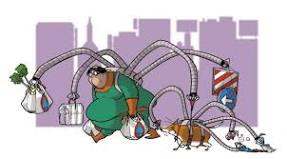

In [0]:
ab = AB(100)
bb = BetaBandit()

for app in [ab,bb]:
  regret, cumulative_regret = run_experiment(app,num_experiments=200)
  plot_cumulative_regret(cumulative_regret, app)

In [0]:
test_application(bb,True)

# Next time: Evaluation of different bandit algorithms

# Next Next time: Contextual Thompson Sampling

Remember how we said "Adding context to our experiment is simple"?

Imagine we want to test if thebackground color is impacting the choice of button. In most frameworks, these would have to be competing experiments (blue button AND white Background vs blue button AND black background vs yellow button AND white background vs blue button vs black background), which lead to combinatorial explosion REALLY quickly (practical example: I will not write this out for any more cases because it's tedious). In Thompson Sampling, we can simply use a model to predict a distribution over the vector [button_color, background_color] and use that to keep doing our experiment. This also means that experimentation and personalization converge at some Point. BUT MORE ON THAT NEXT TIME

## A/B Testing

## Epsilon Greedy

## UCB

## Thompson Sampling


The idea behind Thompson Sampling is as simple as it is genius:

***We sample an action based on how likely it is to be optimal given our current state of knowledge.***

Let's deconstruct that statement:
1. we have observed previous plays with yellow and blue buttons. The yellow ones have so far on average lead to 1/10 clicks, while blue lead to 2/10 click through rate. 
2. Instead of either going with the winner or declaring the outcome inconclusive as we'd do with A/B tests, we sample from a probability distribution derived from the past observations and play the arm with the higher sampled prediction

This, in a way, combines the exploration and the exploitation phase of our AB test: The AB test took a random sample from a rigid distribution during it's exploration phase and then used a hard rule in it's exploitation phase that used the previously encountered evidence to optimize the decision. 
Instead of doing that, we just keep exploring and simply agument the distributions we are sampling from, ad infinitum. This means that Thompson Sampler has several benefits:

1. no end (the distributions will keep updating themselves, we don't need to end the test)
2. self correcting (assume it's now winter and people don't click the yellow button any more - the distributions will shift until the blue button is now being played more often)
3. we can use prior information to minimize business regret (if we have a strong suspicion that the yellow button is more likely to yield a click, we can just give it a more favorable prior distribution - if we're wrong we won't lose too much, see self-correction)
4. converges quicker than AB test (Thompson Sampling usually starts playing the dominant arm quicker) - this leads to minimized regret!
5. We can add new arms whenever we feel like it (let's try out a red button!)
6. Adding context to our experiment is simple. 



 is to choose the action relative to the probability of it being the optimal choice

In [0]:

The idea behind Thompson Sampling is as simple as it is genius:

***We sample an action based on how likely it is to be optimal given our current state of knowledge.***

Let's deconstruct that statement:
1. we have observed previous plays with yellow and blue buttons. The yellow ones have so far on average lead to 1/10 clicks, while blue lead to 2/10 click through rate. 
2. Instead of either going with the winner or declaring the outcome inconclusive as we'd do with A/B tests, we sample from a probability distribution derived from the past observations and play the arm with the higher sampled prediction

This, in a way, combines the exploration and the exploitation phase of our AB test: The AB test took a random sample from a rigid distribution during it's exploration phase and then used a hard rule in it's exploitation phase that used the previously encountered evidence to optimize the decision. 
Instead of doing that, we just keep exploring and simply agument the distributions we are sampling from, ad infinitum. This means that Thompson Sampler has several benefits:

1. no end (the distributions will keep updating themselves, we don't need to end the test)
2. self correcting (assume it's now winter and people don't click the yellow button any more - the distributions will shift until the blue button is now being played more often)
3. we can use prior information to minimize business regret (if we have a strong suspicion that the yellow button is more likely to yield a click, we can just give it a more favorable prior distribution - if we're wrong we won't lose too much, see self-correction)
4. converges quicker than AB test (Thompson Sampling usually starts playing the dominant arm quicker) - this leads to minimized regret!
5. We can add new arms whenever we feel like it (let's try out a red button!)
6. Adding context to our experiment is simple. 



 is to choose the action relative to the probability of it being the optimal choice